In [1]:
import os
import cv2
import pandas as pd
import numpy as np 
#from numpy import expand_dims
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [69]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator#, img_to_array, load_img
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2
import efficientnet.keras as efn
from tensorflow.keras.models import Model, load_model

In [3]:
#importing csv file for the data.
df = pd.read_csv(r"C:\Users\aakas\Documents\DataSets\CNN\ligo minifigure class -- 2\index.csv")
df1 = pd.read_csv(r"C:\Users\aakas\Documents\DataSets\CNN\ligo minifigure class -- 2\metadata.csv")

In [4]:
# Merging the two csv files on 'class_id' column using pd.merge function of pandas.
df = pd.merge(df, df1[['class_id','minifigure_name']], on='class_id')
df.drop('Unnamed: 0', axis=1, inplace = True)
df

,path,class_id,train-valid,minifigure_name
0,marvel/0001/001.jpg,1,train,SPIDER-MAN
1,marvel/0001/002.jpg,1,valid,SPIDER-MAN
2,marvel/0001/003.jpg,1,train,SPIDER-MAN
3,marvel/0001/004.jpg,1,train,SPIDER-MAN
4,marvel/0001/005.jpg,1,train,SPIDER-MAN
...,...,...,...,...
347,marvel/0017/008.jpg,31,valid,IRON MAN MK 50
348,marvel/0017/009.jpg,31,valid,IRON MAN MK 50
349,marvel/0017/010.jpg,31,valid,IRON MAN MK 50
350,marvel/0017/011.jpg,31,valid,IRON MAN MK 50


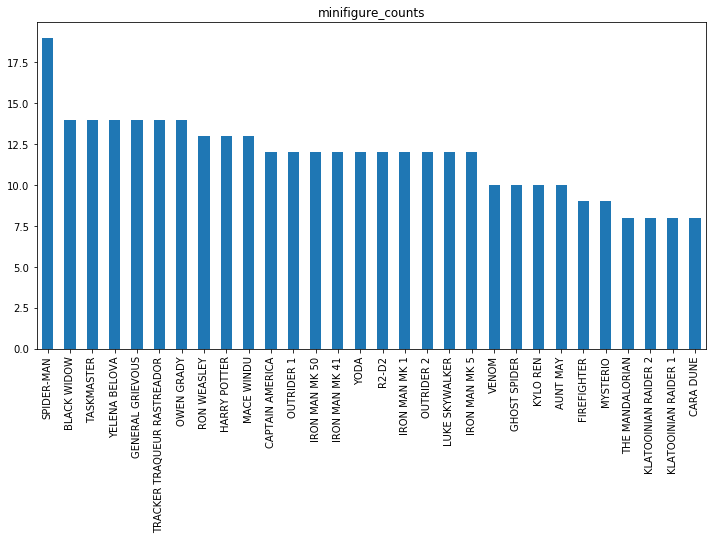

In [5]:
# Graphical Representation of the number of images for each LEGO minifigures availabe in dataset.
df['minifigure_name'].value_counts().plot(kind='bar', figsize=(12,6), title='minifigure_counts')

In [6]:
# Dividing the dataset into train and valid data using 'train-valid' column from the df.
df_train = df[df['train-valid'] == 'train'] # Training data
df_valid = df[df['train-valid'] == 'valid'] # Valid/Test data

In [7]:
print('Shape of training data: ',df_train.shape)
print('Shape of test/valid dataset: ',df_valid.shape)

Shape of training data:  (182, 4)
Shape of test/valid dataset:  (170, 4)


In [8]:
print('no. of classes: ', len(df['class_id'].unique()))

no. of classes:  31


In [9]:
# Location of dataset in local disk.
common_dir = "C:\\Users\\aakas\\Documents\\DataSets\\CNN\\ligo minifigure class -- 2"

In [27]:
# Another way of importing the data.
train_set = df[df['train-valid'] == 'train']
train_set_path = train_set['path'].values
trian_set_path = map(lambda x: os.path.join(common_dir, x), train_set_path)

valid_set = df[df['train-valid'] == 'valid']
valid_set_path = valid_set['path'].values
valid_set_path = map(lambda x: os.path.join(common_dir, x), valid_set_path)

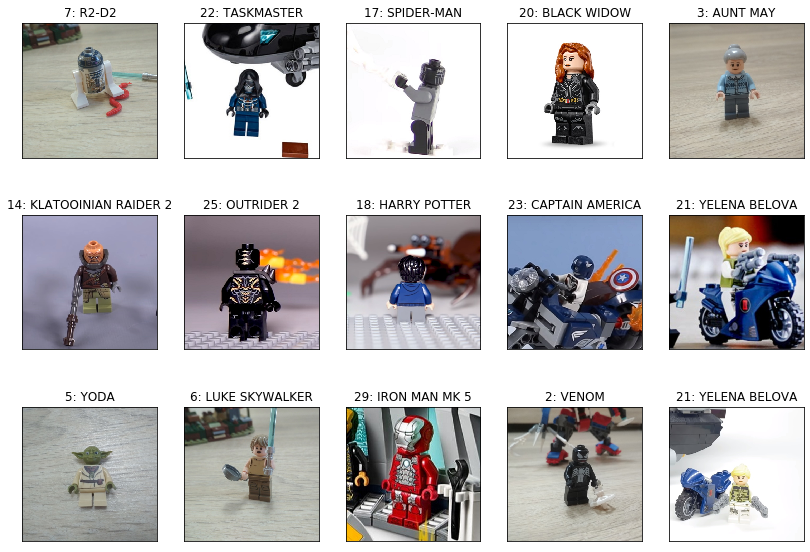

In [10]:
# Graphical Representation of random 15 images(3 rows, 5 columns). 
plt.figure(figsize=(14,10))
for i, j in enumerate(df.sample(15).iterrows(), 1):
    plt.subplot(3,5,i)
    image = cv2.imread(os.path.join(common_dir, j[1]['path']))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(f"{j[1]['class_id']}: {j[1]['minifigure_name']}")
    plt.xticks([])
    plt.yticks([]) 

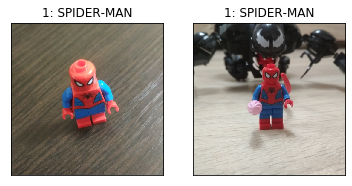

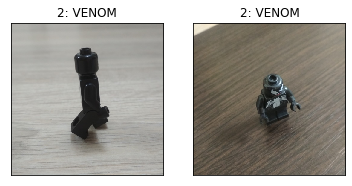

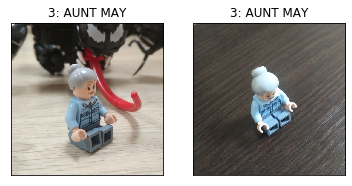

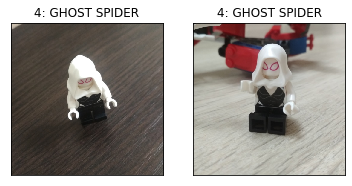

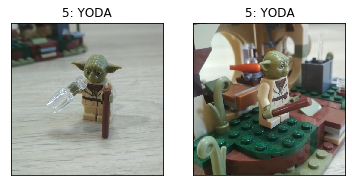

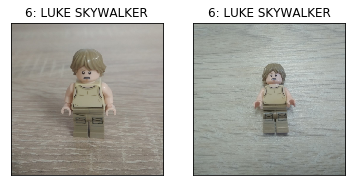

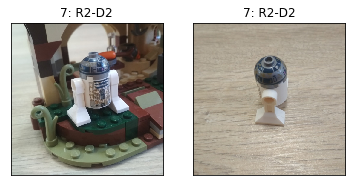

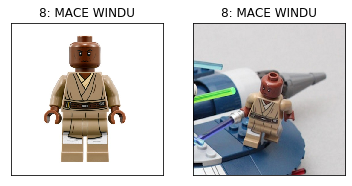

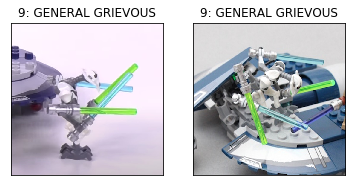

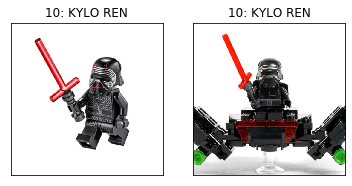

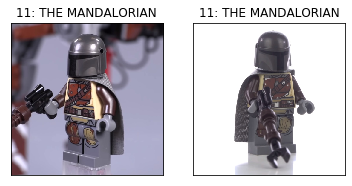

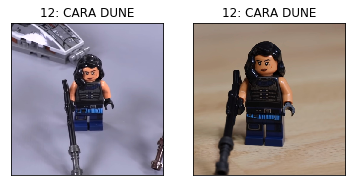

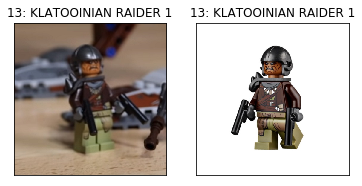

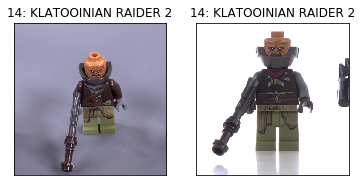

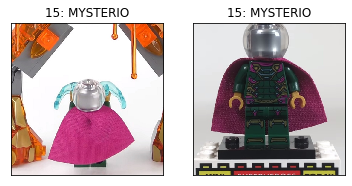

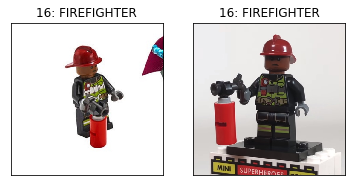

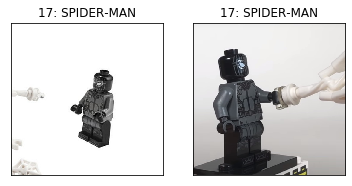

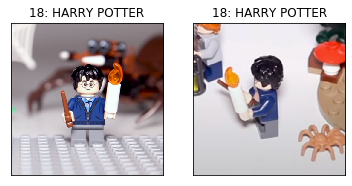

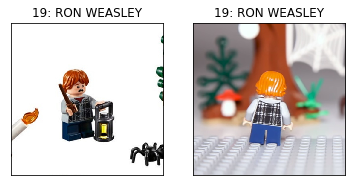

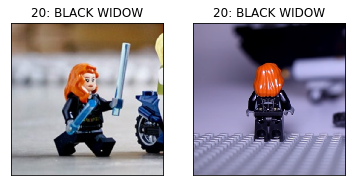

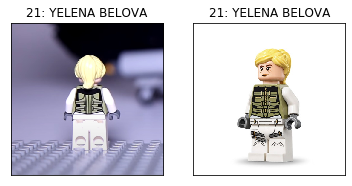

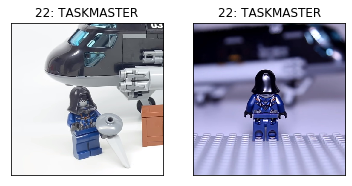

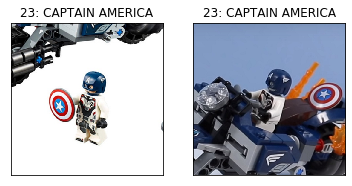

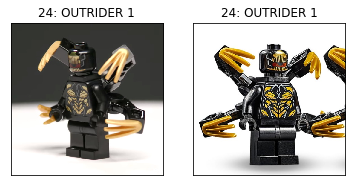

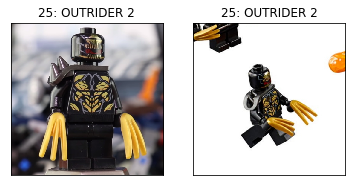

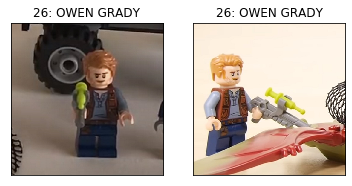

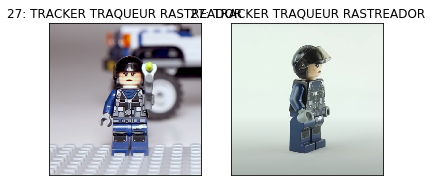

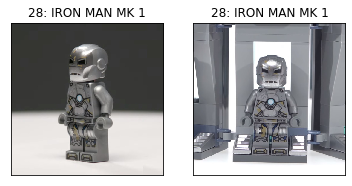

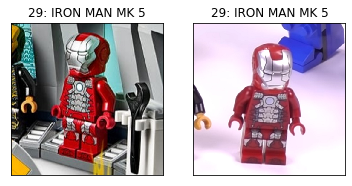

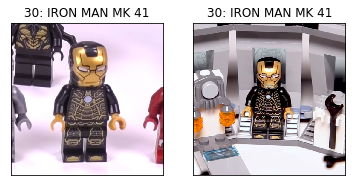

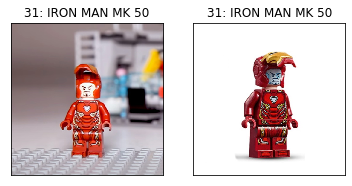

In [11]:
# Here I am importing 2(can be more) random images from each folder.
n_rows = len(df['class_id'].unique()) # 31
n_cols = 2

for row_ind, group in enumerate(df.groupby('class_id')):
    for col_ind, lc in enumerate(group[1].sample(n_cols).iterrows()):
        plt.subplot(1, n_cols, col_ind+1)
        img = cv2.imread(os.path.join(common_dir, lc[1]['path']))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(f"{lc[1]['class_id']}: {lc[1]['minifigure_name']}")
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [12]:
# Data Generator for train and valid datasets.
train_datagen = ImageDataGenerator(rescale=1.0/255, shear_range=0.3, rotation_range=30,
                                   width_shift_range=0.3, height_shift_range=0.3,
                                   brightness_range=[0.2,1.0], horizontal_flip=True, 
                                   vertical_flip= True, fill_mode='nearest',zoom_range=0.4) 
# Try to mold the training data as much as possible for better understanding for the machine.
# There are more ways like blurring and putting hole in the image but you need to make different function for it as these
# features are not available in the ImageDataGenerator.


valid_datagen = ImageDataGenerator(rescale=1.0/255) # Just rescaling the valid data size to match train data.

In [13]:
# Here I am taking size of input_size of images (128,128) as i have kind of crapy local system but you can use (512,512) -
# -for better results. 
# I also tried using AWS(amazon web services) but the free tier ec2 instance only give 8gb of free cloud storage however 
# one need atleast 32gb of cloud storage to run tensorflow as it require many things downloaded and installed.
train_generator = train_datagen.flow_from_dataframe(dataframe=df_train, directory=common_dir, 
                                                    x_col='path',y_col='minifigure_name',shuffle=True,
                                                   target_size=(128,128),batch_size=16)

valid_generator = valid_datagen.flow_from_dataframe(dataframe= df_valid, directory= common_dir,
                                                   x_col='path', y_col='minifigure_name',
                                                   shuffle=False, batch_size=16, target_size=(128,128))

Found 182 validated image filenames belonging to 30 classes.
Found 170 validated image filenames belonging to 30 classes.


In [15]:
# Checkpoint to stop the training after 3 epochs if model dosen't improve the val_loss.
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Checkpoint to save the best model measuring the val_loss.
callbacks_save = ModelCheckpoint('best LEGO-CNN.hdf5', monitor='val_loss', mode='min', save_best_only=True)

# Efficency Net Architecture

I am using the efficencynet architecture to prepare the model and also used the Mobilenet architecture (which has many versions v2 being latest i guess) but i got better results in efficencynet(might be of input size of image which i had to use different in both) plus Mobilenet consumed more time. You can give shot to both at your end.

In [16]:
# Using efficientnet architecture loss: 0.1568 - accuracy: 0.9670 - val_loss: 0.6277 - val_accuracy: 0.8294
base_model = efn.EfficientNetB6(input_shape=(128,128,3), weights='imagenet', include_top=False, pooling='avg')
# Here 3 in input_shape represent channels: In RFB image their are 3 channels(coloured image in simple language).

x = Dropout(0.3)(base_model.output)# adding Droupout layer to the model.
prediction_efn = Dense(30, activation='softmax')(x)
model = Model(base_model.input, prediction_efn)

model.compile(optimizer = Adam(0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [11]:
# Using MobilenetV2 architecture and got loss: 3.2706 \ accuracy: 0.5330 \ val_loss: 3.3082 \ val_accuracy: 0.3706, epoch=50
base_model = MobileNetV2()
x = base_model.output
prediction = Dense(30, activation='softmax')(x)
model = Model(base_model.input, prediction)

model.compile(optimizer=Adam(0.0001), loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [17]:
# fitting the model to training dataset.
model.fit(x=train_generator, validation_data=valid_generator, epochs=100, callbacks=[early_stop, callbacks_save])

Epoch 1/100
12/12 [==============================] - 515s 43s/step - loss: 3.4441 - accuracy: 0.0440 - val_loss: 3.4457 - val_accuracy: 0.0059
Epoch 2/100
12/12 [==============================] - 338s 28s/step - loss: 3.4211 - accuracy: 0.0440 - val_loss: 3.4102 - val_accuracy: 0.0059
Epoch 3/100
12/12 [==============================] - 332s 28s/step - loss: 3.4067 - accuracy: 0.0604 - val_loss: 3.3749 - val_accuracy: 0.0176
Epoch 4/100
12/12 [==============================] - 336s 28s/step - loss: 3.2955 - accuracy: 0.0769 - val_loss: 3.3415 - val_accuracy: 0.0412
Epoch 5/100
12/12 [==============================] - 330s 28s/step - loss: 3.2257 - accuracy: 0.1538 - val_loss: 3.3114 - val_accuracy: 0.0588
Epoch 6/100
12/12 [==============================] - 336s 28s/step - loss: 3.1269 - accuracy: 0.1703 - val_loss: 3.2802 - val_accuracy: 0.0882
Epoch 7/100
12/12 [==============================] - 334s 28s/step - loss: 3.0821 - accuracy: 0.1758 - val_loss: 3.2412 - val_accuracy: 0.1176

Epoch 58/100
12/12 [==============================] - 342s 29s/step - loss: 0.1599 - accuracy: 0.9560 - val_loss: 0.6884 - val_accuracy: 0.8059


In [18]:
loss = model.history.history['loss']
accuracy = model.history.history['accuracy']
val_loss = model.history.history['val_loss']
val_accuracy = model.history.history['val_accuracy']

Text(0.5, 1.0, 'Training and validation loss')

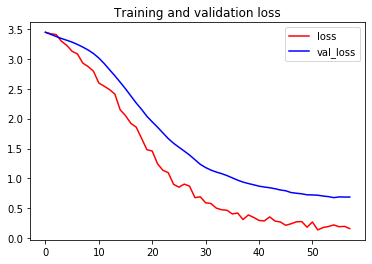

In [19]:
# Plotting Training and Validation set loss.

plt.plot(loss, color='r', label='loss')
plt.plot(val_loss, color='b', label='val_loss')
plt.legend()
plt.title('Training and validation loss')

Text(0.5, 1.0, 'Training and validation Accuracy')

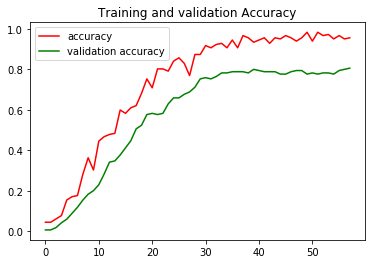

In [20]:
# Plotting Training and Validation set Accuracy.

plt.plot(accuracy, color='r', label='accuracy')
plt.plot(val_accuracy, color='g', label='validation accuracy')
plt.legend()
plt.title('Training and validation Accuracy')

In [22]:
# Calling the saved model. Using load_model from tensorflow models.
model_LEGO = load_model('best LEGO-CNN.hdf5')

Text(0.5, 1.0, 'TASKMASTER')

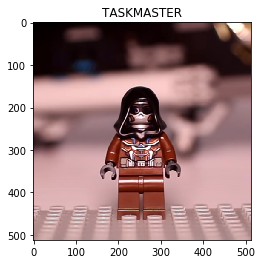

In [135]:
# Importing random Image from valid_dataset.
import random

n = len(df_valid)
random_image = random.randrange(n) # randomly selecting one number.

test_set = df_valid['path'].iloc[random_image] # Picking the image based on randomly selected number.

# Graphically representing the Image.
test_image = cv2.imread(os.path.join(common_dir, test_set))
plt.imshow(test_image)
plt.title(df_valid['minifigure_name'].iloc[random_image])

In [136]:
# Taking the above image and reshaping it for the trained model to accept.
test_image = cv2.resize(test_image, dsize=(128,128))# reshaping the image size into(128,128).
test_image = np.reshape(test_image, (1,128,128,3)) # 1 image, (128,128) size, 3 representing the RGB type.

prediction = model.predict(test_image).argmax() # Feeding the model image to predict.

#### The model will predict the image into an array form giving 31 numbers. When you will run this array into class_id cloumn you will get the name of the predicted image.

As you guys can see above that the input size of images was small so my model had val_loss = 0.62 which does give some wrong answers of the predictions but a high quality image (512,512) can give much better result of the same model.

In [137]:
minifigure_name = df1['minifigure_name'][df1['class_id'] == prediction].iloc[0]
minifigure_name

'TASKMASTER'